In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import warnings
warnings.filterwarnings("ignore")

In [1]:
bit_data=pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv')
bit_data["date"]=pd.to_datetime(bit_data["Timestamp"],unit="s").dt.date
group=bit_data.groupby("date")
data=group["Close"].mean()

NameError: name 'pd' is not defined

What I did here? I added a colum which is "date" and I converted "Timestamp" columns to date form.

In [6]:
data.shape

(2627,)

In [7]:
data.isnull().sum()

0

In [8]:
data.head()

date
2011-12-31    4.482500
2012-01-01    4.806667
2012-01-02    5.000000
2012-01-03    5.252500
2012-01-04    5.223333
Name: Close, dtype: float64

The goal is making a prediction of daily Close data. So we will predict "close" values of bitcoin data

**First I will use RNN to predict our data**

I am separating last 50 rows as the test data.

In [0]:
close_train=data.iloc[:len(data)-50]
close_test=data.iloc[len(close_train):]

Here I will set our values between 0-1 in order to avoid domination of high values.

In [0]:
#feature scalling (set values between 0-1)
close_train=np.array(close_train)
close_train=close_train.reshape(close_train.shape[0],1)
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
close_scaled=scaler.fit_transform(close_train)

Let's choose each 50 data as x-train and 51th as y-train

In [11]:
timestep=50
x_train=[]
y_train=[]

for i in range(timestep,close_scaled.shape[0]):
    x_train.append(close_scaled[i-timestep:i,0])
    y_train.append(close_scaled[i,0])

x_train,y_train=np.array(x_train),np.array(y_train)
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1) #reshaped for RNN
print("x_train shape= ",x_train.shape)
print("y_train shape= ",y_train.shape)

x_train shape=  (2527, 50, 1)
y_train shape=  (2527,)


Time to prepare and run our RNN method

In [12]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout,Flatten

regressor=Sequential()
#first RNN layer
regressor.add(SimpleRNN(128,activation="relu",return_sequences=True,input_shape=(x_train.shape[1],1)))
regressor.add(Dropout(0.25))
#second RNN layer
regressor.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#third RNN layer
regressor.add(SimpleRNN(512,activation="relu",return_sequences=True))
regressor.add(Dropout(0.35))
#fourth RNN layer
regressor.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#fifth RNN layer
regressor.add(SimpleRNN(128,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#convert the matrix to 1-line
regressor.add(Flatten())
#output layer
regressor.add(Dense(1))

regressor.compile(optimizer="adam",loss="mean_squared_error")
regressor.fit(x_train,y_train,epochs=100,batch_size=64)

Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




Epoch 1/100





2527/2527 [==============================] - 12s 5ms/step - loss: 0.0168
Epoch 2/100
2527/2527 [==============================] - 6s 2ms/step - loss: 0.0026
Epoch 3/100
2527/2527 [==============================] - 5s 2ms/step - loss: 0.0017
Epoch 4/100
2527/2527 [==============================] - 5s 2ms/step - loss: 0.0016
Epoch 5/100
2527/2527 [==============================] - 6s 2ms/step - loss: 0.0011
Epoch 6/100
2527/2527 [==============================] - 5s 2ms/step - loss: 9.6372e-04
Epoch 7/100
2527/2527 [==============================] - 5s 2ms/step - loss: 8.3680e-04
Epoch 8/100
2527/2527 [==============================] - 5s 2ms/step - loss: 8.2817e-04
Epoch 9/100
2527/2527 [==============================] - 6s 2ms/step - loss: 8.4453e-04
Epoch 10/100
2527/2527 [==============================] - 6s 2ms/step - loss: 8.4824e-04
Epoch 11/1

Now we are preparing our test data for prediction

In [0]:
inputs=data[len(data)-len(close_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)

In [0]:
x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [0]:
predicted_data=regressor.predict(x_test)
predicted_data=scaler.inverse_transform(predicted_data)

**What did we do???? We learnt our model with train data and then we tried to predict next 50 data (train data=50). Then we compared predictions with our test (real) data.**

In [0]:
data_test=np.array(close_test)
data_test=data_test.reshape(len(data_test),1)

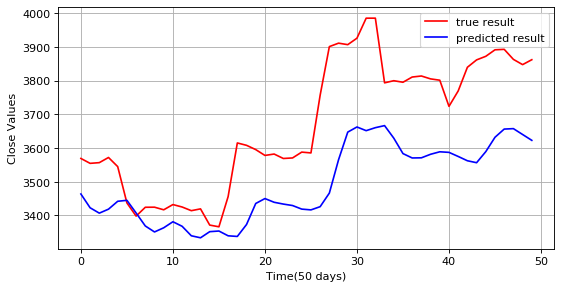

In [17]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="true result")
plt.plot(predicted_data,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(50 days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()

Here we have the results of our prediction. As we can see on the chart that with RNN method we don't have a good result. So let's check LSTM method, then we can compare both results.

**Keep going with LSTM method**

I will use the same train and test data

In [18]:
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,Flatten

model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

model.fit(x_train,y_train,epochs=100,batch_size=32)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
2527/2527 [==============================] - 6s 2ms/step - loss: 0.0417
Epoch 2/100
2527/2527 [==============================] - 5s 2ms/step - loss: 0.0302
Epoch 3/100
2527/2527 [==============================] - 5s 2ms/step - loss: 0.0281
Epoch 4/100
2527/2527 [==============================] - 5s 2ms/step - loss: 0.0277
Epoch 5/100
2527/2527 [==============================] - 5s 2ms/step - loss: 0.0275
Epoch 6/100
2527/2527 [==============================] - 5s 2ms/step - loss: 0.0274
Epoch 7/100
2527/2527 [==============================] - 5s 2ms/step - loss: 0.0274
Epoch 8/100
2527/2527 [==============================] - 5s 2ms/step - loss: 0.0274
Epoch 9/100
2527/2527 [==============================] - 5s 2ms/step - loss: 0.0274
Epoch 10/100
2527/2527 [==============================] - 5s 2ms/step - loss: 0.0274
Epoch 11/100
2527/2527 [==============================] - 5s 2ms/

Keep going with test data

In [0]:
inputs=data[len(data)-len(close_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)

In [0]:
x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

it's time to predict

In [0]:
predicted_data=model.predict(x_test)
predicted_data=scaler.inverse_transform(predicted_data)

In [0]:
data_test=np.array(close_test)
data_test=data_test.reshape(len(data_test),1)

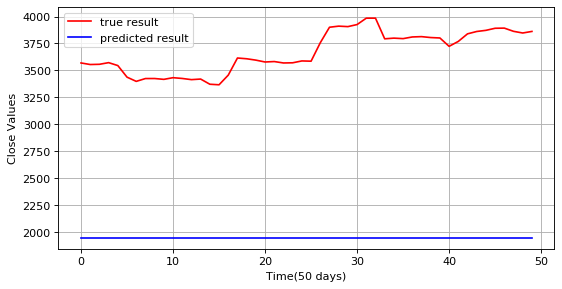

In [23]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="true result")
plt.plot(predicted_data,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(50 days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()

* ** Conclusion**

When we compare the both results (RNN and LSTM) we can see that we have better prediction with LSTM. 

Up to here I was trying to show the differences between RNN - LSTM and how to use these methods on time series. 
